<H1 style="text-align: center">ECMM426 - Computer Vision / ECMM441 - Machine Vision (Professional)</H1>
<H2 style="text-align: center">Coursework 1</H2>
<H2 style="text-align: center">Local Feature Matching</H2>

## Overview

The goal of this coursework is to create a local feature matching algorithm using techniques described in Szeliski chapter 4.1. The pipeline we suggest is a simplified version of the famous SIFT pipeline. The matching pipeline is intended to work for instance-level matching -- multiple views of the same physical scene.

For this project, you need to implement the three major steps of a local feature matching algorithm:

* Interest point detection (see Szeliski 4.1.1)
* Local feature description (see Szeliski 4.1.2)
* Feature Matching (see Szeliski 4.1.3)

This iPython notebook:
1. Loads and resizes images
2. Finds interest points in those images (you code this)
3. Describes each interest point with a local feature (you code this)
4. Finds matching features (you code this)
5. Visualizes the matches
6. Evaluates the matches based on ground truth correspondence

## Submission

* Code (this notebook after completion) **[25 + 10 + 35 + 10 = 80 marks]**
* Report of maximum 2 pages **[20 marks]**

Note that an electronic submission is required. You have to submit this notebook and the PDF report (zipped) electronically at e-BART/ELE. Please have a look on the corresponding module ELE pages for more details on the submission link/page. Any additional files needed to run this Jupyter notebook should be kept within the folder.

**Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission. Please follow the instructions.**

**Acknowledgement:** This coursework is adapted from [Prof James Hays](https://www.cc.gatech.edu/~hays/) of Georgia Institute of Technology.

Although you will undoubtedly work collaboratively in the workshops themselves, these are **individual** exercises.  The reports you write should be about the results **you** obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism.

## Setup

In [222]:
################## GLOBALS

feature_width = 64
bins = 8
k_size = 17
num_corners = 16000
threshold = 0.9

### Imports

In [25]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# install and then import opencv
!pip3 install opencv-python==4.4.0.42
import cv2

## Utils
Some helping functions. Brief comments are added just above the function heading.

In [26]:
# Double to single precision
def im2single(im):
    im = im.astype(np.float32) / 255

    return im

# Single to double precision
def single2im(im):
    im *= 255
    im = im.astype(np.uint8)

    return im

# Convert RGB image to grayscale
def rgb2gray(rgb):
    """Convert RGB image to grayscale
    Args:
    - rgb: A numpy array of shape (m,n,c) representing an RGB image
    Returns:
    - gray: A numpy array of shape (m,n) representing the corresponding grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Load image
def load_image(path):
    """
    Args:
    - path: string representing a filepath to an image
    """
    return im2single(cv2.imread(path))[:, :, ::-1]

# Load annotated points
def cheat_interest_points(eval_file, scale_factor):
    """
    This function is provided for development and debugging but cannot be used in
    the final handin. It 'cheats' by generating interest points from known
    correspondences. It will only work for the 3 image pairs with known
    correspondences.

    Args:
    - eval_file: string representing the file path to the list of known correspondences
    - scale_factor: Python float representing the scale needed to map from the original
            image coordinates to the resolution being used for the current experiment.

    Returns:
    - x1: A numpy array of shape (k,) containing ground truth x-coordinates of imgA correspondence pts
    - y1: A numpy array of shape (k,) containing ground truth y-coordinates of imgA correspondence pts
    - x2: A numpy array of shape (k,) containing ground truth x-coordinates of imgB correspondence pts
    - y2: A numpy array of shape (k,) containing ground truth y-coordinates of imgB correspondence pts
    """
    with open(eval_file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')

    return d['x1'] * scale_factor, d['y1'] * scale_factor, d['x2'] * scale_factor,\
                 d['y2'] * scale_factor

# Stacks 2 images side-by-side and creates one combined image
def hstack_images(imgA, imgB):
    """
    Stacks 2 images side-by-side and creates one combined image.

    Args:
    - imgA: A numpy array of shape (M,N,3) representing rgb image
    - imgB: A numpy array of shape (D,E,3) representing rgb image

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    Height = max(imgA.shape[0], imgB.shape[0])
    Width  = imgA.shape[1] + imgB.shape[1]

    newImg = np.zeros((Height, Width, 3), dtype=imgA.dtype)
    newImg[:imgA.shape[0], :imgA.shape[1], :] = imgA
    newImg[:imgB.shape[0], imgA.shape[1]:, :] = imgB

    return newImg

# Visualized interest points on an image with random colors
def show_interest_points(img, X, Y):
    """
    Visualized interest points on an image with random colors

    Args:
    - img: A numpy array of shape (M,N,C)
    - X: A numpy array of shape (k,) containing x-locations of interest points
    - Y: A numpy array of shape (k,) containing y-locations of interest points

    Returns:
    - newImg: A numpy array of shape (M,N,C) showing the original image with
            colored circles at keypoints plotted on top of it
    """
    newImg = img.copy()
    for x, y in zip(X.astype(int), Y.astype(int)):
        cur_color = np.random.rand(3)
        newImg = cv2.circle(newImg, (x, y), 10, cur_color, -1, cv2.LINE_AA)

    return newImg

# Visualizes corresponding points between two images by plotting circles at each
# correspondence location
def show_correspondence_circles(imgA, imgB, X1, Y1, X2, Y2):
    """
    Visualizes corresponding points between two images by plotting circles at
    each correspondence location. Corresponding points will have the same random color.

    Args:
    - imgA: A numpy array of shape (M,N,3)
    - imgB: A numpy array of shape (D,E,3)
    - x1: A numpy array of shape (k,) containing x-locations of keypoints in imgA
    - y1: A numpy array of shape (k,) containing y-locations of keypoints in imgA
    - x2: A numpy array of shape (j,) containing x-locations of keypoints in imgB
    - y2: A numpy array of shape (j,) containing y-locations of keypoints in imgB

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)

    for x1, y1, x2, y2 in zip(X1, Y1, X2, Y2):
        cur_color = np.random.rand(3) * 255
        green = (0, 255, 0)
        newImg = cv2.circle(newImg, (x1, y1), 10, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x1, y1), 10, green, 2, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 10, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 10, green, 2, cv2.LINE_AA)

    return newImg

# Visualizes corresponding points between two images by drawing a line segment
def show_correspondence_lines(imgA, imgB, X1, Y1, X2, Y2, line_colors=None):
    """
    Visualizes corresponding points between two images by drawing a line segment
    between the two images for each (x1,y1) (x2,y2) pair.

    Args:
    - imgA: A numpy array of shape (M,N,3)
    - imgB: A numpy array of shape (D,E,3)
    - x1: A numpy array of shape (k,) containing x-locations of keypoints in imgA
    - y1: A numpy array of shape (k,) containing y-locations of keypoints in imgA
    - x2: A numpy array of shape (j,) containing x-locations of keypoints in imgB
    - y2: A numpy array of shape (j,) containing y-locations of keypoints in imgB
    - line_colors: A numpy array of shape (N x 3) with colors of correspondence lines (optional)

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)

    dot_colors = np.random.rand(len(X1), 3) * 255
    if line_colors is None:
        line_colors = dot_colors

    for x1, y1, x2, y2, dot_color, line_color in zip(X1, Y1, X2, Y2, dot_colors,
            line_colors):
        newImg = cv2.circle(newImg, (x1, y1), 5, dot_color, -1)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 5, dot_color, -1)
        newImg = cv2.line(newImg, (x1, y1), (x2+shiftX, y2), line_color, 2,
                                            cv2.LINE_AA)
    return newImg

#Show the ground truth correspondeces
def show_ground_truth_corr(imgA, imgB, corr_file, show_lines=True):
    """
    Show the ground truth correspondeces

    Args:
    - imgA: string, representing the filepath to the first image
    - imgB: string, representing the filepath to the second image
    - corr_file: filepath to pickle (.pkl) file containing the correspondences
    - show_lines: boolean, whether to visualize the correspondences as line segments
    """
    imgA = load_image(imgA)
    imgB = load_image(imgB)
    with open(corr_file, 'rb') as f:
        d = pickle.load(f)
    if show_lines:
        return show_correspondence_lines(imgA, imgB, d['x1'], d['y1'], d['x2'], d['y2'])
    else:
        # show circles
        return show_correspondence_circles(imgA, imgB, d['x1'], d['y1'], d['x2'], d['y2'])

# Load ground truth correspondences from a pickle file
def load_corr_pkl_file(corr_fpath):
    """ 
    Load ground truth correspondences from a pickle (.pkl) file. 
    """
    with open(corr_fpath, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
    x1 = d['x1'].squeeze()
    y1 = d['y1'].squeeze()
    x2 = d['x2'].squeeze()
    y2 = d['y2'].squeeze()

    return x1,y1,x2,y2

# Function to evaluate estimated correspondences against ground truth
def evaluate_correspondence(imgA, imgB, corr_fpath, scale_factor, x1_est, y1_est,
        x2_est, y2_est, confidences=None, num_req_matches=100):
    """
    Function to evaluate estimated correspondences against ground truth.

    The evaluation requires 100 matches to receive full credit
    when num_req_matches=100 because we define accuracy as:

    Accuracy = (true_pos)/(true_pos+false_pos) * min(num_matches,num_req_matches)/num_req_matches

    Args:
    - imgA: A numpy array of shape (M,N,C) representing a first image
    - imgB: A numpy array of shape (M,N,C) representing a second image
    - corr_fpath: string, representing a filepath to a .pkl file containing ground truth correspondences
    - scale_factor: scale factor on the size of the images
    - x1_est: A numpy array of shape (k,) containing estimated x-coordinates of imgA correspondence pts
    - y1_est: A numpy array of shape (k,) containing estimated y-coordinates of imgA correspondence pts
    - x2_est: A numpy array of shape (k,) containing estimated x-coordinates of imgB correspondence pts
    - y2_est: A numpy array of shape (k,) containing estimated y-coordinates of imgB correspondence pts
    - confidences: (optional) confidence values in the matches
    """
    if confidences is None:
        confidences = np.random.rand(len(x1_est))
        confidences /= np.max(confidences)

    x1_est = x1_est.squeeze() / scale_factor
    y1_est = y1_est.squeeze() / scale_factor
    x2_est = x2_est.squeeze() / scale_factor
    y2_est = y2_est.squeeze() / scale_factor

    num_matches = x1_est.shape[0]

    x1,y1,x2,y2 = load_corr_pkl_file(corr_fpath)

    good_matches = [False for _ in range(len(x1_est))]
    # array marking which GT pairs are already matched
    matched = [False for _ in range(len(x1))]

    # iterate through estimated pairs in decreasing order of confidence
    priority = np.argsort(-confidences)
    for i in priority:
        # print('Examining ({:4.0f}, {:4.0f}) to ({:4.0f}, {:4.0f})'.format(
        #     x1_est[i], y1_est[i], x2_est[i], y2_est[i]))
        cur_offset = np.asarray([x1_est[i]-x2_est[i], y1_est[i]-y2_est[i]])
        # for each x1_est find nearest ground truth point in x1
        dists = np.linalg.norm(np.vstack((x1_est[i]-x1, y1_est[i]-y1)), axis=0)
        best_matches = np.argsort(dists)

        # find the best match that is not taken yet
        for match_idx in best_matches:
            if not matched[match_idx]:
                break
        else:
            continue

        # A match is good only if
        # (1) An unmatched GT point exists within 150 pixels, and
        # (2) GT correspondence offset is within 25 pixels of estimated
        #     correspondence offset
        gt_offset = np.asarray([x1[match_idx]-x2[match_idx],
            y1[match_idx]-y2[match_idx]])
        offset_dist = np.linalg.norm(cur_offset-gt_offset)
        if (dists[match_idx] < 150.0) and (offset_dist < 25):
            good_matches[i] = True
            print('Correct')
        else:
            print('Incorrect')

    print('You found {}/{} required matches'.format(num_matches, num_req_matches))
    accuracy = np.mean(good_matches) * min(num_matches, num_req_matches)*1./num_req_matches
    print('Accuracy = {:f}'.format(accuracy))
    green = np.asarray([0, 1, 0], dtype=float)
    red = np.asarray([1, 0, 0], dtype=float)
    line_colors = np.asarray([green if m else red for m in good_matches])

    return accuracy, show_correspondence_lines(imgA, imgB,
                                               x1_est*scale_factor, y1_est*scale_factor,
                                               x2_est*scale_factor, y2_est*scale_factor,
                                               line_colors)

## Data

In [27]:
if not os.path.exists('paired_data.zip'):
  !wget --no-check-certificate https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/paired_data.zip
  !unzip -q paired_data.zip

### Notre Dame

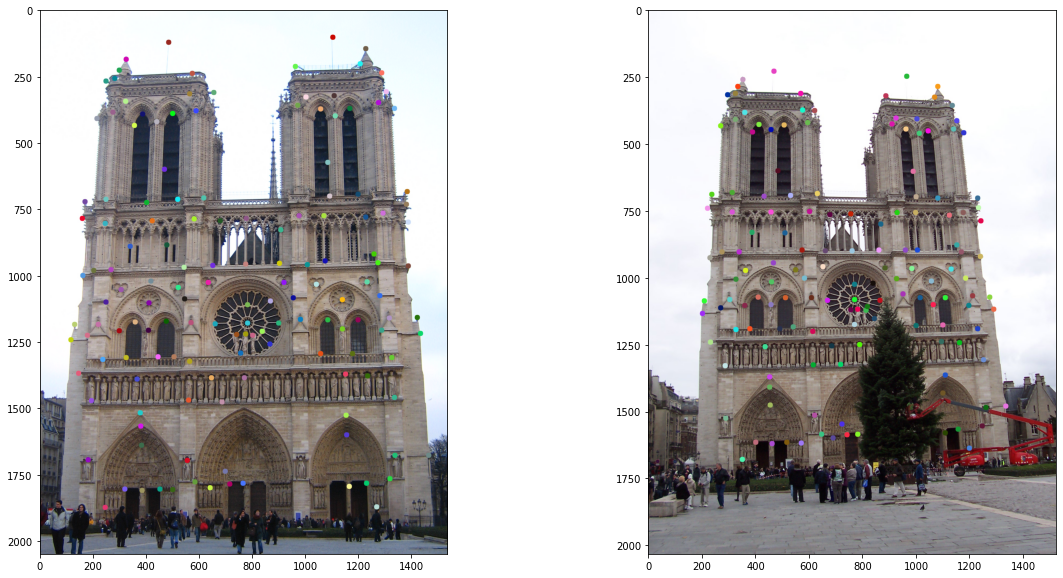

In [91]:
# Notre Dame -- this is the easiest image pair (your work is quite good if you can 
# achieve 85% - 90% matching accuracy on this pair)
scale_factor = 1.0
image1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/921919841_a30df938f2_o.jpg'), cv2.COLOR_BGR2RGB))
image2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/4191453057_c86028ce1f_o.jpg'), cv2.COLOR_BGR2RGB))
eval_file = 'paired_data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1);
plt.subplot(1, 2, 2), plt.imshow(c2);

### Mount Rushmore

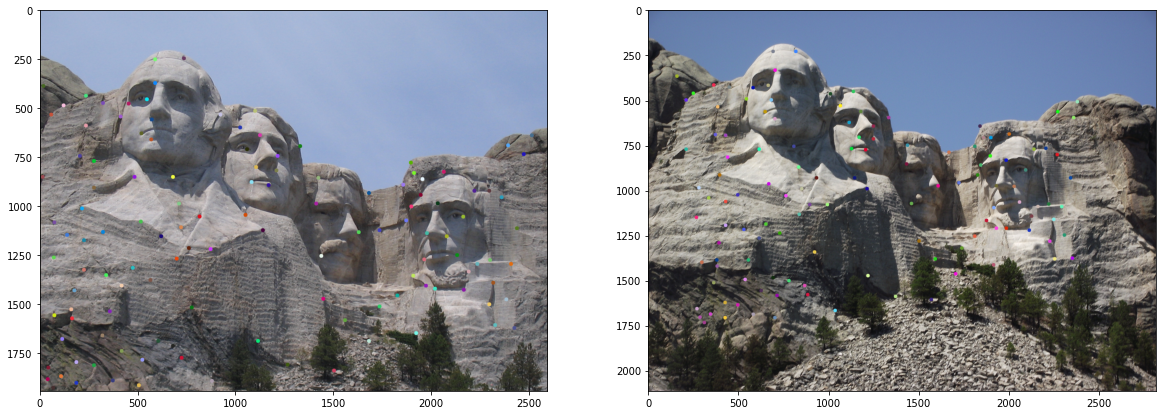

In [168]:
# Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, 
# though) (your work is quite good if you can obtain 80% - 85% matching 
# accuracy on this pair)
scale_factor = 1.0
image1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9021235130_7c2acd9554_o.jpg'), cv2.COLOR_BGR2RGB))
image2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9318872612_a255c874fb_o.jpg'), cv2.COLOR_BGR2RGB))
eval_file = 'paired_data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1);
plt.subplot(1, 2, 2), plt.imshow(c2);

###Episcopal Gaudi

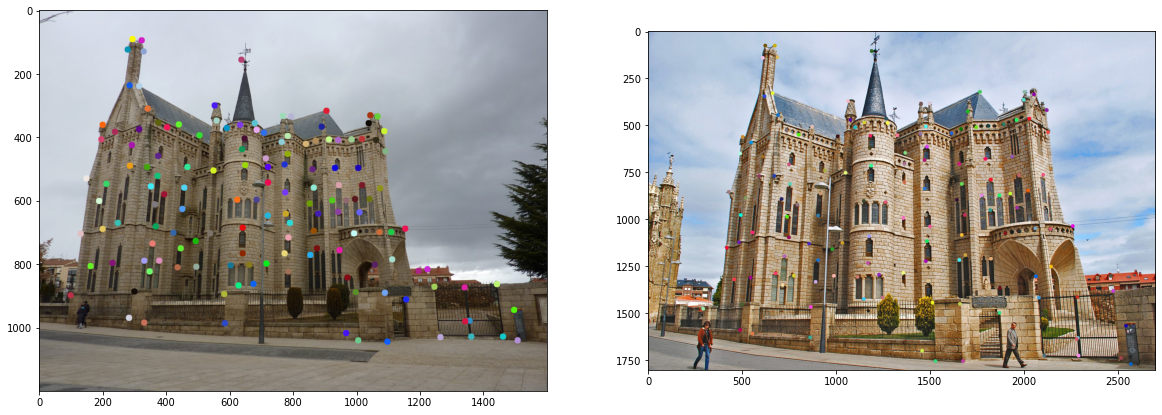

In [207]:
# Episcopal Gaudi -- This pair is relatively difficult (your work is quite good 
# if you can achieve >30% matching accuracy on this pair)
scale_factor = 1.0
image1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg'), cv2.COLOR_BGR2RGB))
image2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg'), cv2.COLOR_BGR2RGB))
eval_file = 'paired_data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1);
plt.subplot(1, 2, 2), plt.imshow(c2);

## 1. Find distinctive points in each image (Szeliski 4.1.1)

You will implement the Harris corner detector as described in the lecture materials and Szeliski 4.1.1. See Algorithm 4.1 in the textbook for pseudocode. The starter code gives some additional suggestions. You do not need to worry about scale invariance or keypoint orientation estimation for your baseline Harris corner detector. The original paper by Chris Harris and Mike Stephens describing their corner detector can be found [here](http://www.bmva.org/bmvc/1988/avc-88-023.pdf).

You will also implement **adaptive non-maximal suppression (ANMS)**. While most feature detectors simply look for local maxima in the interest function, this can lead to an uneven distribution of feature points across the image, e.g., points will be denser in regions of higher contrast. To mitigate this problem, [Brown, Szeliski, and Winder (2005)](https://www.microsoft.com/en-us/research/wp-content/uploads/2005/06/cvpr05.pdf) only detect features that are both local maxima and whose response value is significantly (10%) greater than that of all of its neighbors within a radius r. The goal is to retain only those points that are a maximum in a neighborhood of radius r pixels. One way to do so is to sort all points by the response strength, from large to small response. The first entry in the list is the global maximum, which is not suppressed at any radius. Then, you can iterate through the list and compute the distance to each interest point ahead of it in the list (these are pixels with even greater response strength). The minimum of distances to a keypoint's stronger neighbors (multiplying these neighbors by 0.9 to add robustness) is the radius within which the current point is a local maximum. We call this the suppression radius of this interest point, and you can save these suppression radii. Finally, you can sort the suppression radii from large to small, and return the n keypoints associated with the top n suppression radii, in this sorted order. Feel free to experiment with any n in between 1000 and 2000.

You can read more about **ANMS** in the [textbook](http://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf), this conference [article](https://www.microsoft.com/en-us/research/wp-content/uploads/2005/06/cvpr05.pdf), or in this [paper](https://www.cs.ucsb.edu/~holl/pubs/Gauglitz-2011-ICIP.pdf), or in this [webpage](https://inst.eecs.berkeley.edu/~cs194-26/fa17/upload/files/proj6B/cs194-26-ace/) which describes a fast variant.

* a. Implementation of Harris corner detector **[25 marks]** 
* b. Implementation of adaptive non-maximal suppression **[10 marks]**

In [192]:
import math

def get_interest_points(image, feature_width, k_size=5, k=0.05, num_corners=2000, R_threshold=None):
    """
    Implement the Harris corner detector (See Szeliski 4.1.1) to start with.
    You can create additional interest point detector functions, such as MSER, 
    but that is optional.

    If you're finding spurious interest point detections near the boundaries,
    it is safe to simply suppress the gradients / corners near the edges of
    the image.

    Useful in this function in order to (a) suppress boundary interest
    points (where a feature wouldn't fit entirely in the image, anyway)
    or (b) scale the image filters being used. Or you can ignore it.

    By default you do not need to make scale and orientation invariant
    local features.

    The lecture slides and textbook are a bit vague on how to do the
    non-maximum suppression once you've thresholded the cornerness score.
    You are free to experiment. For example, you could compute connected
    components and take the maximum value within each component.
    Alternatively, you could run a max() operator on each sliding window. You
    could use this to ensure that every interest point is at a local maximum
    of cornerness.

    Args:
    -   image: A numpy array of shape (m, n, c), image may be grayscale or color
            (your choice)
    -   feature_width: integer representing the local feature width in pixels.
    -   these are provisional arguments, please feel free to change if you need.

    Returns:
    -   x: A numpy array of shape (N,) containing x-coordinates of interest points
    -   y: A numpy array of shape (N,) containing y-coordinates of interest points
    -   confidences (optional): numpy nd-array of dim (N,) containing the strength
            of each interest point
    -   scales (optional): A numpy array of shape (N,) containing the scale at each
            interest point
    -   orientations (optional): A numpy array of shape (N,) containing the orientation
            at each interest point

    Hints:
    -   The first part of the problem is very similar to the one done in the 
            workshop on Harris corner point detection.
    -   For the second part, you can run a max() operator on each sliding window
            as mentioned above, which can be a naive approach.
    -   It would be appreciated if you do not use the functions: cv2.cornerHarris(),
            cv2.FastFeatureDetector(), cv2.ORB(), skimage.feature, 
            skimage.feature.hog(), skimage.feature.corner_harris(), 
            skimage.feature.corner_peaks().
    -   You can remove the optional outputs, such as confidences, scales, 
            orientations if you need.
    """
    confidences, scales, orientations = None, None, None
    #############################################################################
    # TODO: YOUR HARRIS CORNER DETECTOR CODE HERE                               #
    #############################################################################

    # Image to gray
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    
    # Gaussian smoothing
    gray_img = cv2.GaussianBlur(gray_img, (k_size, k_size), sigmaX=3, sigmaY=3)

    # construct Sobel kernels
    sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float)
    sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype=np.float)

    # convolution
    I_x = cv2.filter2D(gray_img, -1, sobelX)
    I_y = cv2.filter2D(gray_img, -1, sobelY)

    # gradient covariances
    I_x_I_x = cv2.GaussianBlur(I_x*I_x, (k_size, k_size), sigmaX=3, sigmaY=3)
    I_y_I_y = cv2.GaussianBlur(I_y*I_y, (k_size, k_size), sigmaX=3, sigmaY=3)
    I_x_I_y = cv2.GaussianBlur(I_x*I_y, (k_size, k_size), sigmaX=3, sigmaY=3)

    # calculate determinant and trace
    detA = I_x_I_x * I_y_I_y - I_x_I_y ** 2
    traceA = I_x_I_x + I_y_I_y

    # Harris criteria
    R = detA - k * traceA ** 2
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    #############################################################################
    # TODO: YOUR ADAPTIVE NON-MAXIMAL SUPPRESSION CODE HERE                     #
    # While most feature detectors simply look for local maxima in              #
    # the interest function, this can lead to an uneven distribution            #
    # of feature points across the image, e.g., points will be denser           #
    # in regions of higher contrast. To mitigate this problem, Brown,           #
    # Szeliski, and Winder (2005) only detect features that are both            #
    # local maxima and whose response value is significantly (10%)              #
    # greater than that of all of its neighbors within a radius r. The          #
    # goal is to retain only those points that are a maximum in a               #
    # neighborhood of radius r pixels. One way to do so is to sort all          #
    # points by the response strength, from large to small response.            #
    # The first entry in the list is the global maximum, which is not           #
    # suppressed at any radius. Then, you can iterate through the list          #
    # and compute the distance to each interest point ahead of it in            #
    # the list (these are pixels with even greater response strength).          #
    # The minimum of distances to a keypoint's stronger neighbors               #
    # (multiplying these neighbors by 0.9 to add robustness) is the           #
    # radius within which the current point is a local maximum. We              #
    # call this the suppression radius of this interest point, and we           #
    # save these suppression radii. Finally, we sort the suppression            #
    # radii from large to small, and return the n keypoints                     #
    # associated with the top n suppression radii, in this sorted               #
    # orderself. Feel free to experiment with n=1500.                           #
    #                                                                           #
    # See:                                                                      #
    # https://www.microsoft.com/en-us/research/wp-content/uploads/2005/06/cvpr05.pdf
    # or                                                                        #
    # https://www.cs.ucsb.edu/~holl/pubs/Gauglitz-2011-ICIP.pdf                 #
    #############################################################################
    
    # R-thresholding
    if R_threshold is None:
      R_threshold = 0.02 * np.max(R)

    x, y = np.where(R >= R_threshold)

    Rvals = np.copy(R[x, y])

    # Sort keypoints
    reverse_idx = np.argsort(Rvals)[::-1]
    Rvals = Rvals[reverse_idx]
    x = x[reverse_idx]
    y = y[reverse_idx]

    suppression_rs = np.zeros(len(Rvals))

    # Iterate through Rvals
    for i in range(len(Rvals)):
      if i == 0:
        suppression_rs[i] = np.Infinity
        continue
      
      # Check if significant difference between this and next largest neighbour
      if Rvals[i] < Rvals[i - 1] * 0.9:

        # Compute distance between current point and another point
        dsts = np.sqrt(((x[:i] - x[i]) ** 2 + (y[:i] - y[i]) ** 2))

        # Get min distance
        min_dst = np.min(dsts)

        # Get index of keypoint with min radii
        suppression_rs[i] = min_dst
      else:
        suppression_rs[i] = 0
    
    reverse_idx = np.argsort(suppression_rs)[::1]
    suppression_rs = suppression_rs[reverse_idx]
    x = x[reverse_idx][:num_corners]
    y = y[reverse_idx][:num_corners]

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return x, y, confidences, scales, orientations

16000 corners in image 1, 16000 corners in image 2


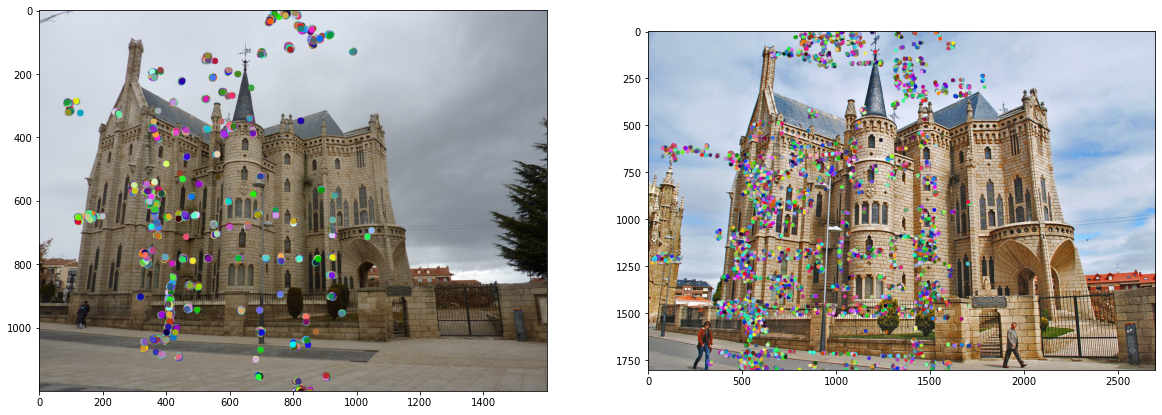

In [223]:
# Once you have the `get_interest_points' function ready, you can use the 
# following two lines
x1, y1, _, scales1, _ = get_interest_points(image1, feature_width, k_size=k_size, num_corners=num_corners, R_threshold=None) 
x2, y2, _, scales2, _ = get_interest_points(image2, feature_width, k_size=k_size, num_corners=num_corners, R_threshold=None)

# Otherwise, you load the ground truth points
# x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1);
plt.subplot(1, 2, 2), plt.imshow(c2);
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

## 2. Create feature vectors at each interest point (Szeliski 4.1.2)
You will implement a SIFT-like local feature as described in the lecture materials and Szeliski 4.1.2. See the placeholder get_features() for more details. If you want to get your matching pipeline working quickly (and maybe to help debug the other algorithm stages), you might want to start with normalized patches as your local feature.
* a. Implementation of SIFT-like local feature **[35 marks]**

In [93]:
def get_features(image, x, y, feature_width, scales=None, bins=8):
    """
    To start with, you might want to simply use normalized patches as your
    local feature. This is very simple to code and works OK. However, to get
    full credit you will need to implement the more effective SIFT descriptor
    (See Szeliski 4.1.2 or the original publications at
    http://www.cs.ubc.ca/~lowe/keypoints/)

    A basic version of SIFT implementation with proper parameter should achieve 
    quite good results and the following three steps are those basic steps. Your
    implementation does not need to exactly match the SIFT reference paper. Here 
    are the key properties your (baseline) descriptor should have:
    (1) a 4 x 4 grid of cells, each feature_width/4. It is simply the
        terminology used in the feature literature to describe the spatial
        bins where gradient distributions will be described.
    (2) each cell should have a histogram of the local distribution of
        gradients in 8 orientations. Appending these histograms together will
        give you 4 x 4 x 8 = 128 dimensions.
    (3) Each feature should be normalized to unit length.

    You do not have to explicitly compute the gradient orientation at each
    pixel (although you are free to do so). You can instead filter with
    oriented filters (e.g. a filter that responds to edges with a specific
    orientation) on the whole image. All of your SIFT-like feature can be 
    constructed entirely from filtering fairly quickly in this way.

    You do not need to do the normalize -> threshold -> normalize again
    operation as detailed in Szeliski and the SIFT paper. It can help, though.

    Another simple trick which can help is to raise each element of the final
    feature vector to some power that is less than one.

    Args:
    -   image: A numpy array of shape (m,n) or (m,n,c). can be grayscale or color, your choice
    -   x: A numpy array of shape (k,), the x-coordinates of interest points
    -   y: A numpy array of shape (k,), the y-coordinates of interest points
    -   feature_width: integer representing the local feature width in pixels.
            You can assume that feature_width will be a multiple of 4 (i.e. every
                cell of your local SIFT-like feature will have an integer width
                and height). This is the initial window size you examine around
                each keypoint.
    -   scales: Python list or tuple if you want to detect and describe features
            at multiple scales
    -   these are provisional arguments, please feel free to change if you need.

    You may also detect and describe features at particular orientations.

    Returns:
    -   fv: A numpy array of shape (k, feat_dim) representing a feature vector.
            "feat_dim" is the feature_dimensionality (e.g. 128 for standard SIFT).
            These are the computed features.

    Hints:
    -   Some useful functions are: np.arctan2(), np.sort(), np.gradient(), 
            np.histogram(), np.hypot(), np.fliplr(), np.flipud(), cv2.Sobel(), 
            cv2.filter2D(), cv2.getGaussianKernel(), scipy.signal.convolve()
    -   Try varying the sizes of different kernels, patches etc.
    -   You can try computing more than one feature descriptor for a single 
            keypoint to increase matching accuracy (optional).
    """
    sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Find angles and mags
    angles = np.arctan2(sobelY, sobelX)
    mags = np.sqrt(sobelX ** 2 + sobelY ** 2)

    half_feature_width = feature_width // 2
    hist_cell_width = half_feature_width // 2

    fv = []

    # Iterate through keypoints
    for aPoint, val in enumerate(x):
      x1 = int(x[aPoint])
      y1 = int(y[aPoint])

      # Get patches
      angles_patch = angles[y1 - half_feature_width : y1 + half_feature_width, x1 - half_feature_width : x1 + half_feature_width]
      mags_patch = mags[y1 - half_feature_width : y1 + half_feature_width, x1 - half_feature_width : x1 + half_feature_width]
      sifts = []

      # Use patch
      for i in range(0, feature_width, hist_cell_width):
        for j in range(0, feature_width, hist_cell_width):

          # Get bins for patches
          angles_patch_bin = angles_patch[i : i + hist_cell_width, j : j + hist_cell_width]
          mags_patch_bin = mags_patch[i : i + hist_cell_width, j : j + hist_cell_width]

          # Create histogram
          hist, bins = np.histogram(angles_patch_bin, bins=bins, range=(-np.pi, np.pi), weights=mags_patch_bin)
          sifts.extend(hist)
      
      sifts = np.array(sifts)
      fv.append(sifts)
    
    fv = np.array(fv)
    fv = fv**.7

    return fv

In [224]:
# Once you have the `get_features' function ready, execute the followings
image1_features = get_features(image1, x1, y1, feature_width, scales1, bins=bins)
image2_features = get_features(image2, x2, y2, feature_width, scales2, bins=bins)

## 3. Match features (Szeliski 4.1.3)
You will implement the "ratio test" or "nearest neighbor distance ratio test" method of matching local features as described in the lecture materials and Szeliski 4.1.3. See equation 4.18 in particular. The potential matches that pass the ratio test the easiest should have a greater tendency to be correct matches -- think about why.
* a. Implementation of "ratio test" matching **[10 marks]**

In [104]:
from sklearn.metrics.pairwise import euclidean_distances

def match_features(features1, features2, x1, y1, x2, y2, threshold=0.75):
    """
    This function does not need to be symmetric (e.g. it can produce
    different numbers of matches depending on the order of the arguments).

    To start with, simply implement the "ratio test", equation 4.18 in
    section 4.1.3 of Szeliski. There are a lot of repetitive features in
    these images, and all of their descriptors will look similar. The
    ratio test helps us resolve this issue (also see Figure 11 of David
    Lowe's IJCV paper).

    For improvement, you can implement a form of spatial/geometric verification 
    of matches, e.g. using the x and y locations of the features. One of these 
    is graph or point matching.

    Args:
    -   features1: A numpy array of shape (n,feat_dim) representing one set of
            features, where feat_dim denotes the feature dimensionality
    -   features2: A numpy array of shape (m,feat_dim) representing a second set
            features (m not necessarily equal to n)
    -   x1: A numpy array of shape (n,) containing the x-locations of features1
    -   y1: A numpy array of shape (n,) containing the y-locations of features1
    -   x2: A numpy array of shape (m,) containing the x-locations of features2
    -   y2: A numpy array of shape (m,) containing the y-locations of features2
    -   these are provisional arguments, please feel free to change if you need

    Returns:
    -   matches: A numpy array of shape (k,2), where k is the number of matches.
            The first column is an index in features1, and the second column is
            an index in features2
    -   confidences: A numpy array of shape (k,) with the real valued confidence for
            every match

    Hints:
    -   A similar task is done in the workshop on Feature Description and 
            Matching.
    -   Matching can be improved by imposing structural or positional 
            constraints in terms of graph, i.e. graph or point matching, but 
            that would be quite tricky and hence, it is optional. You can also 
            come out with your own method for improving matching accuracy 
            (optional). 

    'matches' and 'confidences' can be empty e.g. (0x2) and (0x1)
    """

    dsts = euclidean_distances(features1, features2)

    # Sort dsts
    inds = np.argsort(dsts, axis=1)
    sorted_dsts = np.take_along_axis(dsts, inds, axis=1)

    # Nearest Neighbour Dst Ratio
    scores = sorted_dsts[:, 0] / sorted_dsts[:, 1]

    idx = scores < threshold
    confidences = 1 / scores[idx]

    k = confidences.shape[0]
    matches = np.zeros((k, 2), dtype=int)

    # Matches where score or distance < threshold
    matches[:, 0] = np.where(idx)[0]
    matches[:, 1] = inds[idx, 0]

    # Arrange matches and confidences in descending order
    idx = (-confidences).argsort()
    matches = matches[idx, :]
    confidences = confidences[idx]

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return matches, confidences

In [220]:
# Once you have the `match_features' function ready, execute the followings
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2, threshold=threshold)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

135 matches from 4000 corners


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


## 4. Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


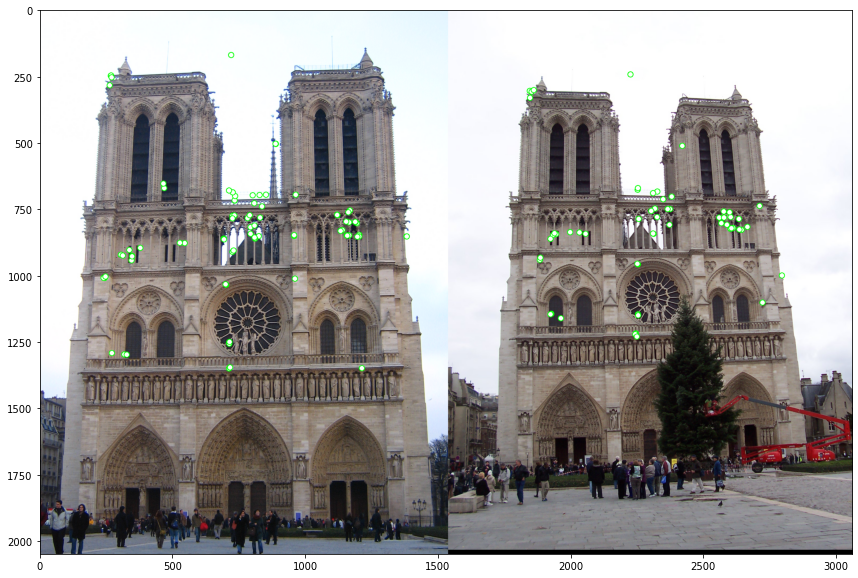

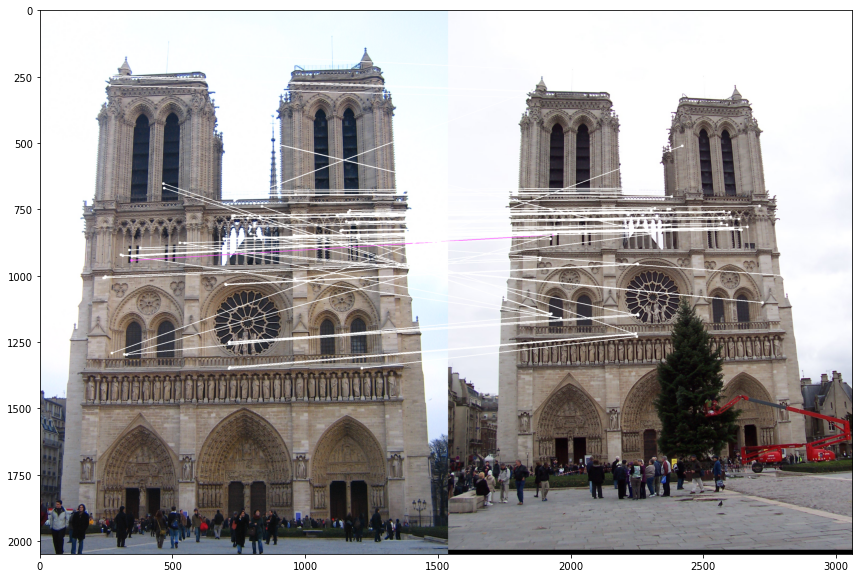

In [148]:
num_pts_to_visualize = len(matches)

c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect


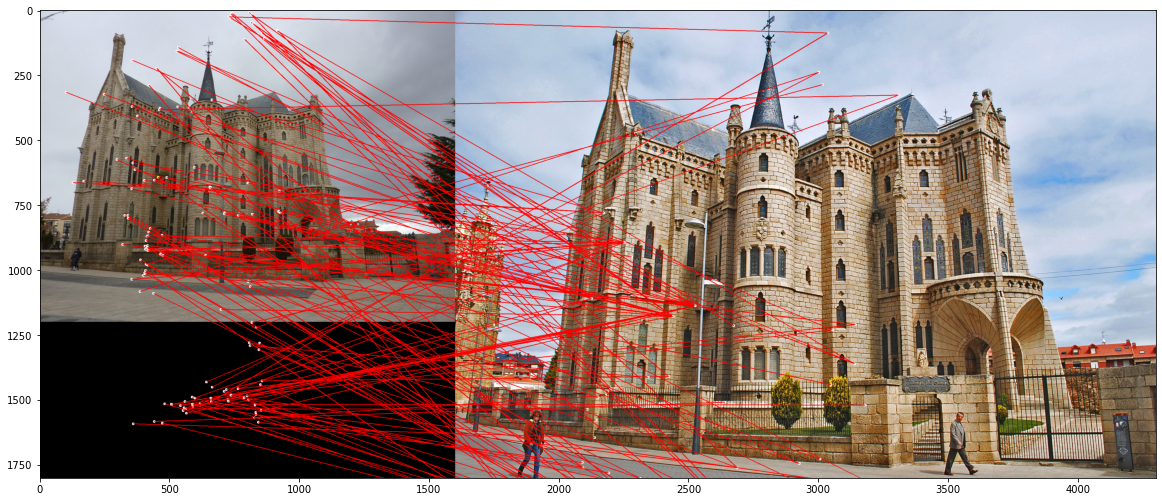

In [225]:
num_pts_to_evaluate = len(matches)

_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)

## 5. Report

* For this project, you must write a **project report** in PDF (**maximum 2 pages**). In the report you will describe your algorithm (details on implementation, settings etc) and any decisions you made to write your implementation in a particular way. Then you will show and discuss the results of your method. For the last two parts (part 2 and 3 above) of your work, if you obtain better matching accuracy and your code is correct, you will obtain better marks.

* In the case of this project, show how well your matching method works on the Notre Dame, Mount Rushmore, Episcopal Gaudi image pairs. A good writeup will assess how important various design decisions were. E.g. by using SIFT-like features instead of normalized patches, I went from 45% good matches to 85% good matches. This is especially important if you do some of the extra tasks to improve the matching accuracy. 

* To clarify it further, let's assume that the Notre Dame pair needs a wider patch or feature size (may be because the annotated keypoints need larger context) than that for the Episcopal Gaudi pair. Write in the report why does Notre Dame pair need wider patch size? An example of reason could be since Notre Dame has two symmetrical pillars, considering bigger patch helps distinguishing them from the other. 

* As another example, let's say, with larger (bigger $\sigma$) Gaussian smoothing, you obtain better result on a particular image pair. It would be nice, if you can explain or speculate the reason behind it. You should clearly demonstrate how your additions (if any) changed the behavior on particular test cases. 

* Again, just to clarify that with the basic versions of SIFT descriptors and feature matching implementations, you should obtain 85%-90% accuracy on the Notre Dame image pair, 80% - 85% accuracy on the Mount Rushmore image pair and 30% - 35% accuracy on Episcopal Gaudi image pair. Write your report with example of matchings or qualitative results. 

* If you are interested (i.e. you enjoy the work so far), you can also collect similar image pairs (as these three image pairs) by your own, and try your implementations (detection, feature description and matching) and include the qualitative results in your report, which will definitely improve the quality of your report. Remember that you can not calculate accuracy on those images collected by you, as they dont have ground truth matchings. 

**[20 marks]**